### Predict values based on RNN trained in [RNN_Train_StLaurentDeJourdes](RNN_Train_StLaurentDeJourdes.ipynb) 

---

In [1]:
#Import Modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib, joblib
from pickle import load
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# import psutil
function_folder = '../Modules/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
from oriVariables import (simResult_folder)

In [11]:
from oriVariables import (simResult_folder, 
                          network_folder, 
                          hm10_start_end, 
                          h_start_end, 
                          valSet_start_M2, 
                          pd_Δt, 
                          testSet_end_M1)

#### Import data Cleaned file for testing set

In [8]:
df_data = joblib.load(simResult_folder+'StLaurent_cleanedData.pkl')


per_index = df_data.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object)
                .between_time(*h_start_end) 
               ).index.to_period(pd_Δt)

# Extract the number of periods considered in a day
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])

# Extract testing set periods whole data
df_test = df_data[(df_data.index >= valSet_start_M2) & (df_data.index<=testSet_end_M1)]

# Extract only dailight period i.e. in the testing set
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. Each day total period is therefore given by 10*6
per_daylight = ( pd.Series(index=df_test.index.to_timestamp(), dtype=object)
                .between_time(*hm10_start_end) 
               ).index.to_period(pd_Δt)

df_test=df_test.loc[per_daylight]


### Import trained RNN parameters

In [ ]:
# Load scaler and RNN from file
scaler = joblib.load(f'{network_folder}RNN/StLaurent_Final_Scaler.pkl')
lstm_model = tf.keras.models.load_model(f'{network_folder}RNN/RnnStLaurent_Final')

#### Define history

In [13]:
histTot = df_test.rolling(day_tot_per) # Create a rolling windows to get the history

#### Predict values

In [16]:
hist_list = list(histTot)
len_hist = len(hist_list)
n0  = day_tot_per                 # The first elem 
pred_per, pred = [],[]             
                
for hist_index in tqdm(range(n0, len_hist)):
    cur_hist = hist_list[hist_index]          # current hystory
    
    # run prediction for each period 
    pred_var, pred_per_var = oriFc.prediction_bloc(rnn_model=lstm_model, 
                                                   fitting_scaler=scaler, 
                                                   history= cur_hist)
    
    pred_per.append(pred_per_var)
    pred.append(pred_var)
    


100%|██████████| 26646/26646 [24:25<00:00, 18.18it/s] 


#### Define a dataframe of predicted values


In [17]:
predicted_values = pd.DataFrame(np.array(pred).reshape((len(pred),-1)),
                                index=pred_per, 
                                columns = df_test.columns+'_RNN' )

In [18]:
# Redefine prediction periods without 7PM
per_daylight2 = (pd.Series(index=predicted_values.index.to_timestamp(), dtype=object).between_time(*h_start_end)).index.to_period(pd_Δt)

# extract the predicted periods based on  per_daylight2
predicted_values = predicted_values.loc[per_daylight2]


#### Concatanate real and predicted df values

In [42]:
df_final = pd.concat([df_test.iloc[n0+1:,:], predicted_values], axis=1)
df_final = df_final.loc[per_daylight2]

df_final.head()

,Cons,Prod_BT,P0013,P0018,P0100,Cons_RNN,Prod_BT_RNN,P0013_RNN,P0018_RNN,P0100_RNN
2021-06-02 07:00,7.563,0.527,0.020,0.018,0.333,7.688129,0.510646,0.005181,0.002437,0.194658
2021-06-02 07:10,7.451,0.568,0.021,0.020,0.274,7.908918,0.570782,0.026894,0.021193,0.350617
2021-06-02 07:20,7.549,0.671,0.019,0.020,0.254,7.805867,0.636820,0.023820,0.020293,0.285356
2021-06-02 07:30,7.853,0.648,0.028,0.028,0.271,7.846136,0.751392,0.024791,0.023078,0.267684
2021-06-02 07:40,7.713,0.508,0.024,0.026,0.309,8.016215,0.651703,0.026394,0.022836,0.310298


#### Scatter plot prediction and Real values

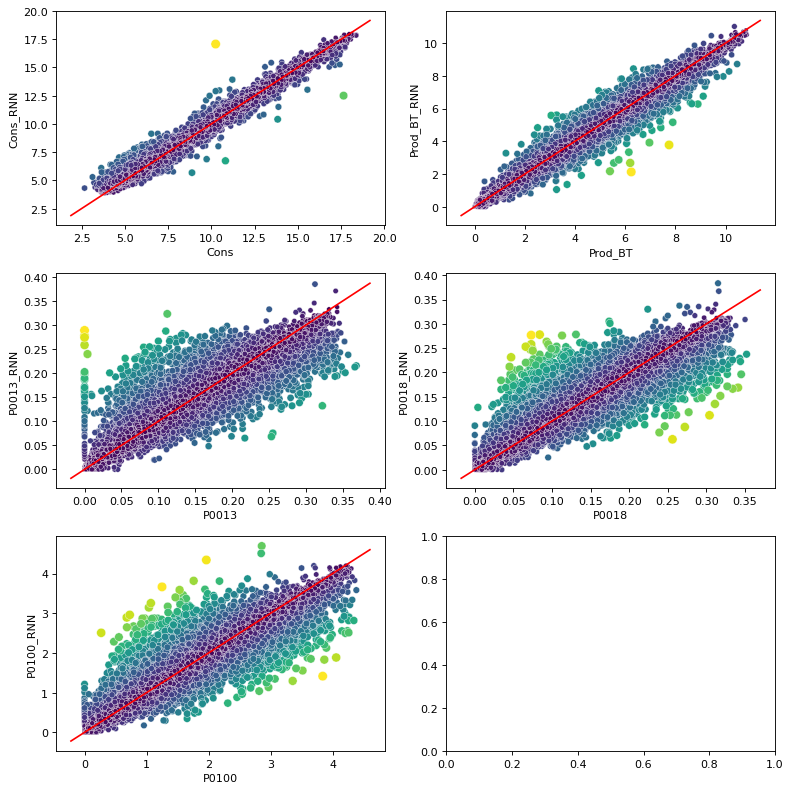

In [20]:
fig, axx = plt.subplots(3,2, figsize=(10,10), dpi=80)

for cur_col, cur_ax in zip(df_test.columns, axx.flatten()):
    ee = abs(df_final[cur_col] - df_final[cur_col+'_RNN']).values
    # sbn.scatterplot(x=cur_col, y=cur_col+'_Pred', data=df_final, ax=cur_ax, hue=ee,size=ee, legend=False,)
    sbn.scatterplot(x=cur_col, y=cur_col+'_RNN', data=df_final, ax=cur_ax, 
                    size=ee, hue=ee, 
                    palette=sbn.color_palette("viridis", as_cmap=True)
                    ,legend=False,)
    
    cur_ax.plot(cur_ax.get_xlim(), cur_ax.get_xlim(),color='red')
    # cur_ax.set(xlim=[0,cur_ax.get_xlim()[1] ], ylim=[0, cur_ax.get_ylim()[1]])
    
fig.tight_layout()

#### Create new dataframe with index covering all periods of all days


In [37]:
# Get year, month and day from the final df
dfirst_year, dfirst_month, dfirst_day = df_final.index[0].year,df_final.index[0].month,df_final.index[0].day
dlast_year, dlast_month, dlast_day = df_final.index[-1].year,df_final.index[-1].month,df_final.index[-1].day

# create first and last period to be used to create new df index
per_first = f'{dfirst_year} {dfirst_month} {dfirst_day}'
per_last = f'{dlast_year} {dlast_month} {dlast_day+1}'
new_per = pd.period_range(start=per_first, end=per_last, freq=pd_Δt)

# create new df
new_df = pd.DataFrame(data=0, index=new_per, columns=df_final.columns)

# put the final df inton the new df
new_df.loc[df_final.index] = df_final

#### Plot real values vs Predicted Values

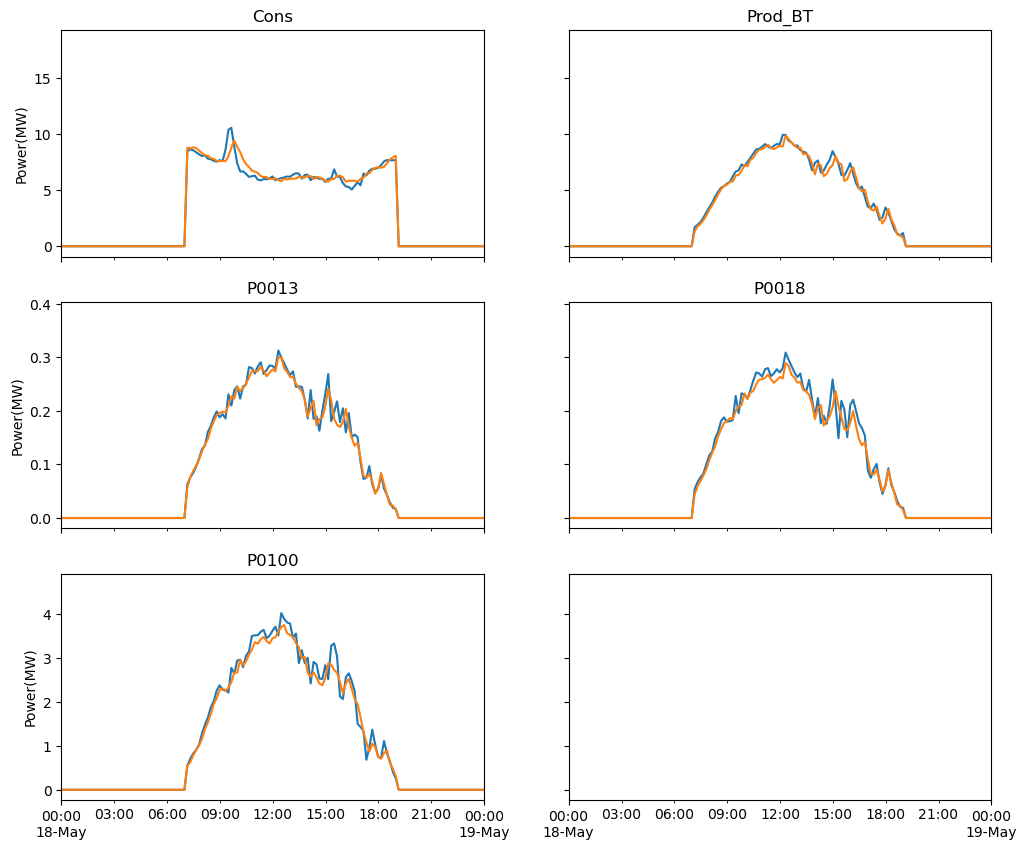

In [38]:
date_lim = ('05 18 2022', '05 19 2022')

fig, axx = plt.subplots(3,2, figsize=(12,10), dpi=100, sharex=True, sharey='row')
for cur_col, cur_ax in zip(df_test.columns, axx.flatten()):
    w2plot= [cur_col, cur_col+'_RNN']
    new_df[w2plot].plot(xlim=date_lim,ax=cur_ax, 
                        legend=False, title=cur_col,ylabel='Power(MW)')


##### <span style='color:red'> Look in [Figures](../Figures/) for images curves or real and predicted variables</span>*

#### Plot statistic on prediction error

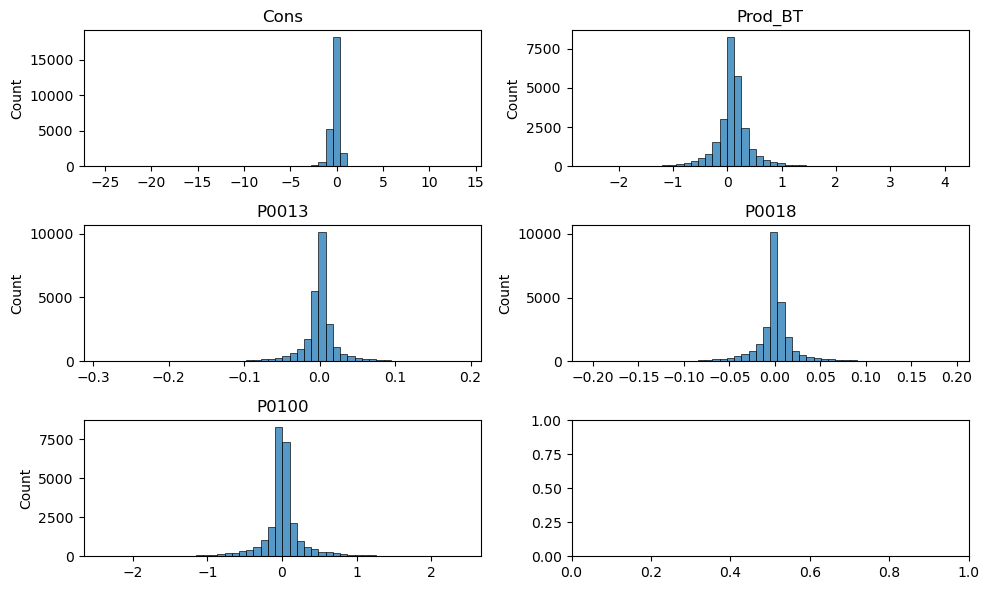

In [109]:
fig, axx = plt.subplots(3,2, figsize=(10,6), dpi=100)

for cur_col, cur_ax in zip(df_test.columns, axx.flatten()):
    ee = (df_final[cur_col] - df_final[cur_col+'_RNN']).values
    # sbn.scatterplot(x=cur_col, y=cur_col+'_Pred', data=df_final, ax=cur_ax, hue=ee,size=ee, legend=False,)
    sbn.histplot(ee, ax=cur_ax, bins=50,  )
    cur_ax.set(title=cur_col)
    

fig.tight_layout()

In [39]:
var =[]
print(f'Prediction Mean absolute Error: ')
for cur_col in df_test:
    val = mean_absolute_error(df_final[cur_col], df_final[cur_col+'_RNN'])
    var.append(val)
    print(f'--- {cur_col:<10}: {val:<1.2} MW')

Prediction Mean absolute Error: 
--- Cons      : 0.32 MW
--- Prod_BT   : 0.24 MW
--- P0013     : 0.015 MW
--- P0018     : 0.014 MW
--- P0100     : 0.17 MW


In [40]:
mean_var = df_test.loc[per_daylight2].mean()

var2 = np.array(var)*100/mean_var
print(f'Prediction Error percentage : ')
for cur_col in df_test:
    print(f'--- {cur_col:<10}: {var2[cur_col]:<5.2f} %')

Prediction Error percentage : 
--- Cons      : 3.68  %
--- Prod_BT   : 6.92  %
--- P0013     : 13.77 %
--- P0018     : 13.61 %
--- P0100     : 14.00 %


In [41]:
# Save results values
joblib.dump(predicted_values, f'{simResult_folder}RNN_pred.pkl')

['../Pickle_files/simulationResults/RNN_pred.pkl']